In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [489]:
# Loading data
# _month: monthly data
# _week: weekly data
# 100: S&P 100, otherwise DOW 30


bm_month_df = pd.read_csv('bm.csv')
ret_month_df = pd.read_csv('ret.csv')
msci_month_df = pd.read_csv('esgset.csv')

bm100_month_df = pd.read_csv('bm1.csv')
ret100_month_df = pd.read_csv('ret1.csv')
msci100_month_df = pd.read_csv('esgset1.csv')

bm_week_df = pd.read_csv('bm2.csv')
ret_week_df = pd.read_csv('ret2.csv')
msci_week_df = pd.read_csv('esgset2.csv')

esg_twitter_month_df = pd.read_csv('../climate_score_month.csv').fillna(0)
esg_twitter_week_df = pd.read_csv('../climate_score_week.csv').fillna(0)
esg_twitter_month_df = esg_twitter_month_df[['time', 'UNH', 'GS', 'HD', 'MSFT', 'MCD', 'AMGN', 'CAT', 'MA', 'HON', 'CRM', 'TRV', 'JNJ', 'CVX', 'AXP', 'AAPL', 'MMM', 'PG', 'IBM', 'BA', 'JPM', 'WMT', 'NKE', 'DIS', 'MRK', 'DOW', 'KO', 'T', 'CSCO', 'INTC', 'WBA']]
esg_twitter_week_df = esg_twitter_week_df[['time', 'UNH', 'GS', 'HD', 'MSFT', 'MCD', 'AMGN', 'CAT', 'MA', 'HON', 'CRM', 'TRV', 'JNJ', 'CVX', 'AXP', 'AAPL', 'MMM', 'PG', 'IBM', 'BA', 'JPM', 'WMT', 'NKE', 'DIS', 'MRK', 'DOW', 'KO', 'T', 'CSCO', 'INTC', 'WBA']]





In [490]:
bm_month = bm_month_df.iloc[:, 1:].to_numpy(dtype=float)
ret_month = ret_month_df.iloc[:, 1:].to_numpy(dtype=float)
msci_month = msci_month_df.iloc[:, 1:].to_numpy(dtype=float)

esg_twitter_month = esg_twitter_month_df.iloc[:-5, 1:].to_numpy(dtype=float)
esg_twitter_week = esg_twitter_week_df.iloc[5:313, 1:].to_numpy(dtype=float)

In [491]:


bm100_month = bm100_month_df.iloc[:, 1:].to_numpy(dtype=float)
ret100_month = ret100_month_df.iloc[:, 1:].to_numpy(dtype=float)
msci100_month = msci100_month_df.iloc[:, 1:].to_numpy(dtype=float)

In [492]:


bm_week = bm_week_df.iloc[:, 1:].to_numpy(dtype=float)
ret_week = ret_week_df.iloc[:, 1:].to_numpy(dtype=float)
msci_week = msci_week_df.iloc[:, 1:].to_numpy(dtype=float)



In [493]:
def z_score(mat):
    """
    mat (2-D np.array)
    returns: cross sectional z-score (across columns)
    """
    (num_periods, num_stocks) = mat.shape


    for t in range(num_periods):
        m = mat[t, :].mean()
        s = mat[t, :].std()
        mat[t, :] = (mat[t, :] - m) / s

    return mat

bm_month = z_score(bm_month)
bm100_month = z_score(bm100_month)
bm_week = z_score(bm_week)
esg_twitter_month = z_score(esg_twitter_month)
esg_twitter_week = z_score(esg_twitter_week)
msci_month = z_score(msci_month)
maxi100_month = z_score(msci100_month)
msci_week = z_score(msci_week)

In [494]:
def c_ab(a, sigma_inv, b):
    """"
    definition see equation (9)
    return: a' sigma^-1 b
    """

    return a @ sigma_inv @ b

def sr(s_bar, mu, sigma, s):
    """
    s_bar (scaler): fixed portfolio average esg score
    mu (1-D array): mu[i] is the return of stock i
    sigma (2-D array): covariance matrix of returns
    s (1-D array): s[i] is the esg scores of stock i
    """

    # avoid numerical error and make sure inv(sigma) is positive definite
    if np.amin(np.linalg.eigvals(sigma)) < 0:
        sigma += np.eye(*sigma.shape) * 1e-17

    assert np.amin(np.linalg.eigvals(sigma)) > 0

    one = np.ones((len(mu)))
    # sigma_inv = np.linalg.inv(sigma)
    sigma_inv = np.linalg.pinv(sigma)

    sr_sq = c_ab(mu, sigma_inv, mu) - (c_ab(s, sigma_inv, mu) - s_bar * c_ab(one, sigma_inv, mu)) ** 2 / (c_ab(s, sigma_inv, s) - 2 * s_bar * c_ab(one, sigma_inv, s) + s_bar ** 2 * c_ab(one, sigma_inv, one))

    assert sr_sq >= 0


    return np.sqrt(sr_sq)

def opt_port(s_bar, mu, sigma, s):
    """
    return: 1-D array
    """
    # # avoid numerical error and make sure inv(sigma) is positive definite
    if np.amin(np.linalg.eigvals(sigma)) < 0:
        sigma += np.eye(*sigma.shape) * 1e-17

    assert np.amin(np.linalg.eigvals(sigma)) > 0

    # sigma_inv = np.linalg.inv(sigma)
    sigma_inv = np.linalg.pinv(sigma)
        

    one = np.ones((len(mu)))
    pi =  (c_ab(one, sigma_inv, mu) * s_bar - c_ab(s, sigma_inv, mu)) / (c_ab(s, sigma_inv, s) - 2 * c_ab(one, sigma_inv, s) * s_bar + c_ab(one, sigma_inv, one) * s_bar ** 2)
    x = sigma_inv @ (mu + pi * (s - one * s_bar))
    return x.reshape((len(mu)))





In [495]:
def ret_est(ret, factors, esg=None, simple_method=True):
    """

    factors (list of matrix, factors[k].shape = (num_periods, num_stocks)): factors[0][t, i] could be the book-to-market ratio of stock i at time t
    esg (shape = (num_periods, num_stocks)): esg[t, i] is the esg score of stock i at time t
    ret (shape = (num_periods, num_stocks)): ret[t, i] is the return of stock i from time t - 1 to t
    esg: (shape = (num_periods, num_stocks)): leave it out for unaware investors
    simple_method: use the simple method (constant factor premium) if True, or time-varying risk if False

    returns: np.array with shape = (num_periods - 1, num_stocks)
    """
    num_periods, num_stocks = ret.shape
    num_factors = len(factors) + 1 if esg is None else len(factors) + 2 # type U factors: [const, factor1, ..., factor_K]; type A factors: [const, factor1, ..., factor_K, esg]


    # E_t(r_{t+1})
    exp_ret = np.zeros((num_periods - 1, num_stocks))

    # E_t(F_{t+1})
    exp_factor_premium = np.zeros((num_periods - 1, num_factors))

    # f_hat[t, :] is F_hat_{t+1}
    f_hat = np.zeros((num_periods - 1, num_factors))

    for t in range(num_periods - 1):


        # x = np.ones((num_stocks, num_factors))

        # # print(np.array([factor[t, :] for factor in factors]).shape)
        # if esg is None:
        #     x[:, 1:-1] = np.array([factor[t, :] for factor in factors]).T
        # else:
        #     x[:, 1:] = np.append(np.array([factor[t, :] for factor in factors]), esg[t, :]).T

        x = np.array([factor[t, :] for factor in factors])
        if esg is not None:
            x = np.row_stack((x, esg[t, :]))


        x = np.row_stack((np.ones(x.shape[1]), x))
        x = x.T


        # x[:, 1:] = np.array([factor[t, :] for factor in factors]).T
        # if esg is not None:
        #     x[:, 1:] = x[:, 1:].T.append(esg[t, :]).T
            
        sigma = np.eye(num_stocks)

        theta = np.linalg.inv(x.T @ np.linalg.inv(sigma) @ x) @ x.T @ np.linalg.inv(sigma)

        # =========================================
        # Barra

        theta_ols = theta
        ret_hat_up_to_t_plus_1 = x @ theta_ols @ ret[:t + 1, :].T

        res = ret[:t + 1, :] - ret_hat_up_to_t_plus_1.T # res.shape = (t, num_factors)



        res_var = np.nanvar(res, axis=0, ddof=1) if res.shape[0] >=2 else np.ones(num_stocks)
        sigma = np.diag(res_var) 

            
        theta_gls = np.linalg.inv(x.T @ np.linalg.inv(sigma) @ x) @ x.T @ np.linalg.inv(sigma)
        theta = theta_gls
        #==========================================

        f_hat[t, :] = theta @ ret[t + 1, :]

        if simple_method:
            # E_t(F_{t+1}) = (f_hat_{t0} + ... f_hat_{t}) / (t-t0) : not allowed to use information of ret[t+1, :]

            # t0 = 0
            t0 = max([0, t - num_periods // 8])
            if t > t0 + 1:
                exp_factor_premium[t, :] = np.nanmean(f_hat[t0:t, :], axis=0) # recall t is not inclusive in indexing
            

        else:
            # time-varying factor premium with constant SR
            sigma_f = np.zeros(num_factors)

            sigma_stocks = np.cov(ret[:t, :].T)
            # sigma_stocks = np.cov(ret[:t, :].T, dtype=np.float128)


            for k in range(num_factors):
                
                sigma_f[k] = np.sqrt(theta[k, :] @ sigma_stocks @ theta[k, :].T)
            

            sr_f = np.nanmean(f_hat[:t, :], axis=0) / np.nanstd(f_hat[:t, :], axis=0)

            exp_factor_premium[t, :] = sigma_f * sr_f
            

        exp_ret[t, :] = x @ exp_factor_premium[t, :]

    if simple_method:
        return exp_ret[1:, :]
    else:
        return exp_ret[2:, :]

In [496]:
def plot_frontier(ret, bm, esg, ante, aware=False, s_bar_min=-3, s_bar_max=3, simple_method=True):
    """
    ret: realized returns
    bm: bm ratio
    esg: esg score
    """



    n_grid = 50


    if not aware:
        # exp_ret[t, :] is the E_t(r_{t+1})
        exp_ret = ret_est(ret, bm, simple_method=simple_method)
    else:
        exp_ret = ret_est(ret, bm, esg, simple_method=simple_method)


    s = esg
    
    num_periods, num_stocks = exp_ret.shape
    
    # last n periods used to draw the curves
    num_curves = 10
    assert num_curves <= num_periods - 1

    s_bar = np.linspace(s_bar_min, s_bar_max, n_grid)
    sr_ante = np.zeros((num_periods, n_grid))
    sr_post = np.zeros((num_periods, n_grid))
    x = np.zeros((num_periods, num_stocks))

    start_date = num_periods - num_curves


    num_frontiers_ante = num_periods - start_date
    num_frontiers_post = num_frontiers_ante - 1

    for i in range(n_grid):
        for t in range(start_date, num_periods): # estimation of sigma is way off for t small
            sigma_t = np.cov(ret[:t+1, :].T) # sigma estimated using realized returns from time 0 to t
            mu_t_ante = exp_ret[t, :]

            sr_ante[t, i] = sr(s_bar[i], mu_t_ante, sigma_t, s[t])


            x[t, :] = opt_port(s_bar[i], mu_t_ante, sigma_t, s[t])

            if t > start_date:
                x_last = x[t-1, :]

                mu_t_post = ret[t, :]
                sr_post[t, i] = np.dot(x_last, mu_t_post) / np.sqrt(x_last @ sigma_t @ x_last)



    sr_ante_avg = sr_ante.sum(axis=0) / num_frontiers_ante
    sr_post_avg = sr_post.sum(axis=0) / num_frontiers_post


    investor = " Type A" if aware else "Type U"

    if ante:
        plt.plot(s_bar, sr_ante_avg, label = investor)
        plt.legend()
        plt.title('Ex-Ante')
        # for line in range(num_frontiers_ante):
        #     plt.plot(s_bar, sr_ante[-num_frontiers_ante + line], label = line)
        # plt.legend()
        
    else:
        plt.plot(s_bar, sr_post_avg, label = investor)
        plt.legend()
        plt.title('Ex-Post')
        # for line in range(num_frontiers_post):
        #     plt.plot(s_bar, sr_post[-num_frontiers_post + line], label = line)
        # plt.legend()
        


In [497]:
data_month = (ret_month, [bm_month], msci_month)
data100_month = (ret100_month, [bm100_month], msci100_month)
data_week = (ret_week, [bm_week], msci_week)
data_twitter_month = (ret_month, [bm_month], esg_twitter_month)
data_twitter_week = (ret_week, [bm_week], esg_twitter_week)

esg_rand = np.random.randn(*ret_month.shape)
esg_rand = z_score(esg_rand)
data_esg_rand = (ret_month, [bm_month], esg_rand)


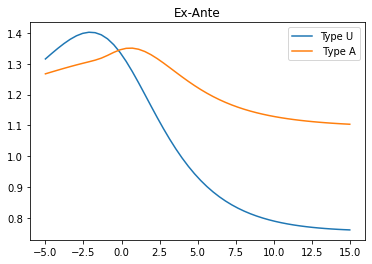

In [498]:
plot_frontier(*data_month, ante = True, s_bar_min = -5, s_bar_max = 15, aware=False)
plot_frontier(*data_month, ante = True,  s_bar_min = -5, s_bar_max = 15, aware=True)

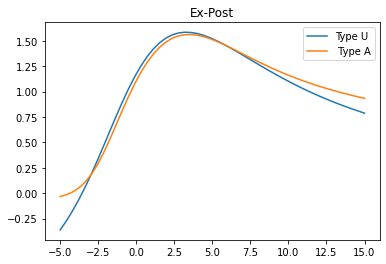

In [499]:
plot_frontier(*data_month, s_bar_min = -5, s_bar_max = 15, ante = False, aware=False)
plot_frontier(*data_month, s_bar_min = -5, s_bar_max = 15, ante = False, aware=True)

In [500]:
r = 10
l = -10

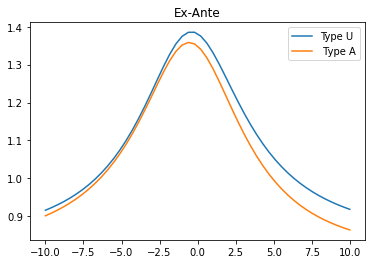

In [501]:
plot_frontier(*data_twitter_month, ante = True,  s_bar_min = l, s_bar_max = r, aware=False)
plot_frontier(*data_twitter_month, ante = True,  s_bar_min = l, s_bar_max = r, aware=True)

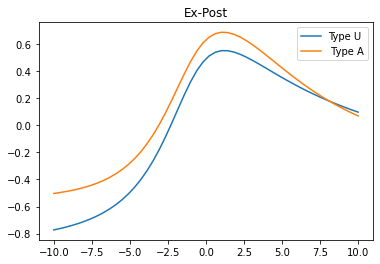

In [502]:
plot_frontier(*data_twitter_month, ante = False, s_bar_min = l, s_bar_max = r, aware=False)
plot_frontier(*data_twitter_month, ante = False, s_bar_min = l, s_bar_max = r, aware=True)

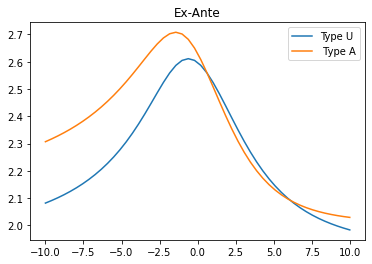

In [503]:
plot_frontier(*data100_month, ante = True,  s_bar_min = l, s_bar_max = r, aware=False, simple_method=True)
plot_frontier(*data100_month, ante = True,  s_bar_min = l, s_bar_max = r, aware=True, simple_method=True)

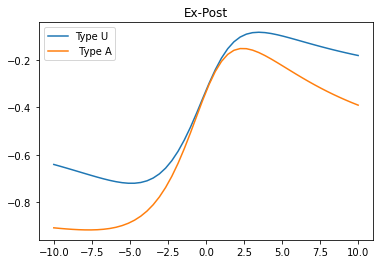

In [504]:
plot_frontier(*data100_month, ante = False, s_bar_min = l, s_bar_max = r, aware=False)
plot_frontier(*data100_month, ante = False, s_bar_min = l, s_bar_max = r, aware=True)

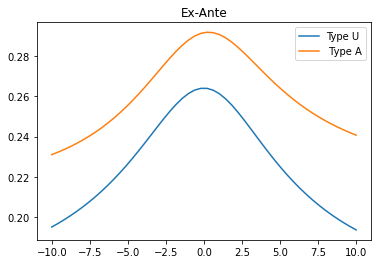

In [505]:
plot_frontier(*data_twitter_week, ante = True, s_bar_min = l, s_bar_max = r, aware=False)
plot_frontier(*data_twitter_week, ante = True, s_bar_min = l, s_bar_max = r, aware=True)

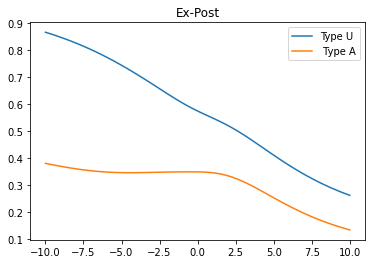

In [506]:
plot_frontier(*data_twitter_week, ante = False, s_bar_min = l, s_bar_max = r, aware=False)
plot_frontier(*data_twitter_week, ante = False, s_bar_min = l, s_bar_max = r, aware=True)

In [507]:
esg_rand = np.random.randn(*ret.shape)
esg_rand = z_score(esg_rand)

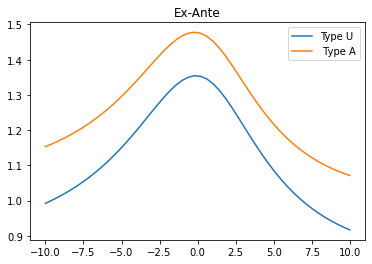

In [508]:
plot_frontier(*data_esg_rand, s_bar_min = l, s_bar_max = r, ante = True, aware=False)
plot_frontier(*data_esg_rand, s_bar_min = l, s_bar_max = r, ante = True, aware=True)

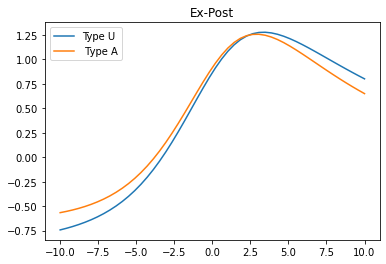

In [509]:
plot_frontier(*data_esg_rand, s_bar_min = l, s_bar_max = r, ante = False, aware=False)
plot_frontier(*data_esg_rand, s_bar_min = l, s_bar_max = r, ante = False, aware=True)